# Heart Attack Prediction

In [42]:
%matplotlib inline
import matplotlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
matplotlib.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
heart_df = pd.read_csv("/content/drive/MyDrive/ML /Real_heart_attack_prediction/Data/heart.csv")
heart_df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [46]:
print(heart_df.info())
print("-------------------------------")
print(heart_df.describe())
print("-------------------------------")
print(f"Count of NaN values in dataset:{heart_df.isna().sum().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None
-------------------------------
              age         sex          cp      trtbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337   

In [47]:
# Visualise data for better understanding
pairplot = sns.pairplot(heart_df, hue ='output')
pairplot.add_legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

* The pair chart shows that the combination between thalachh(resting blood pressure) and age together and thall(Thal rate) by itself seperates the two target labels efficiantly.

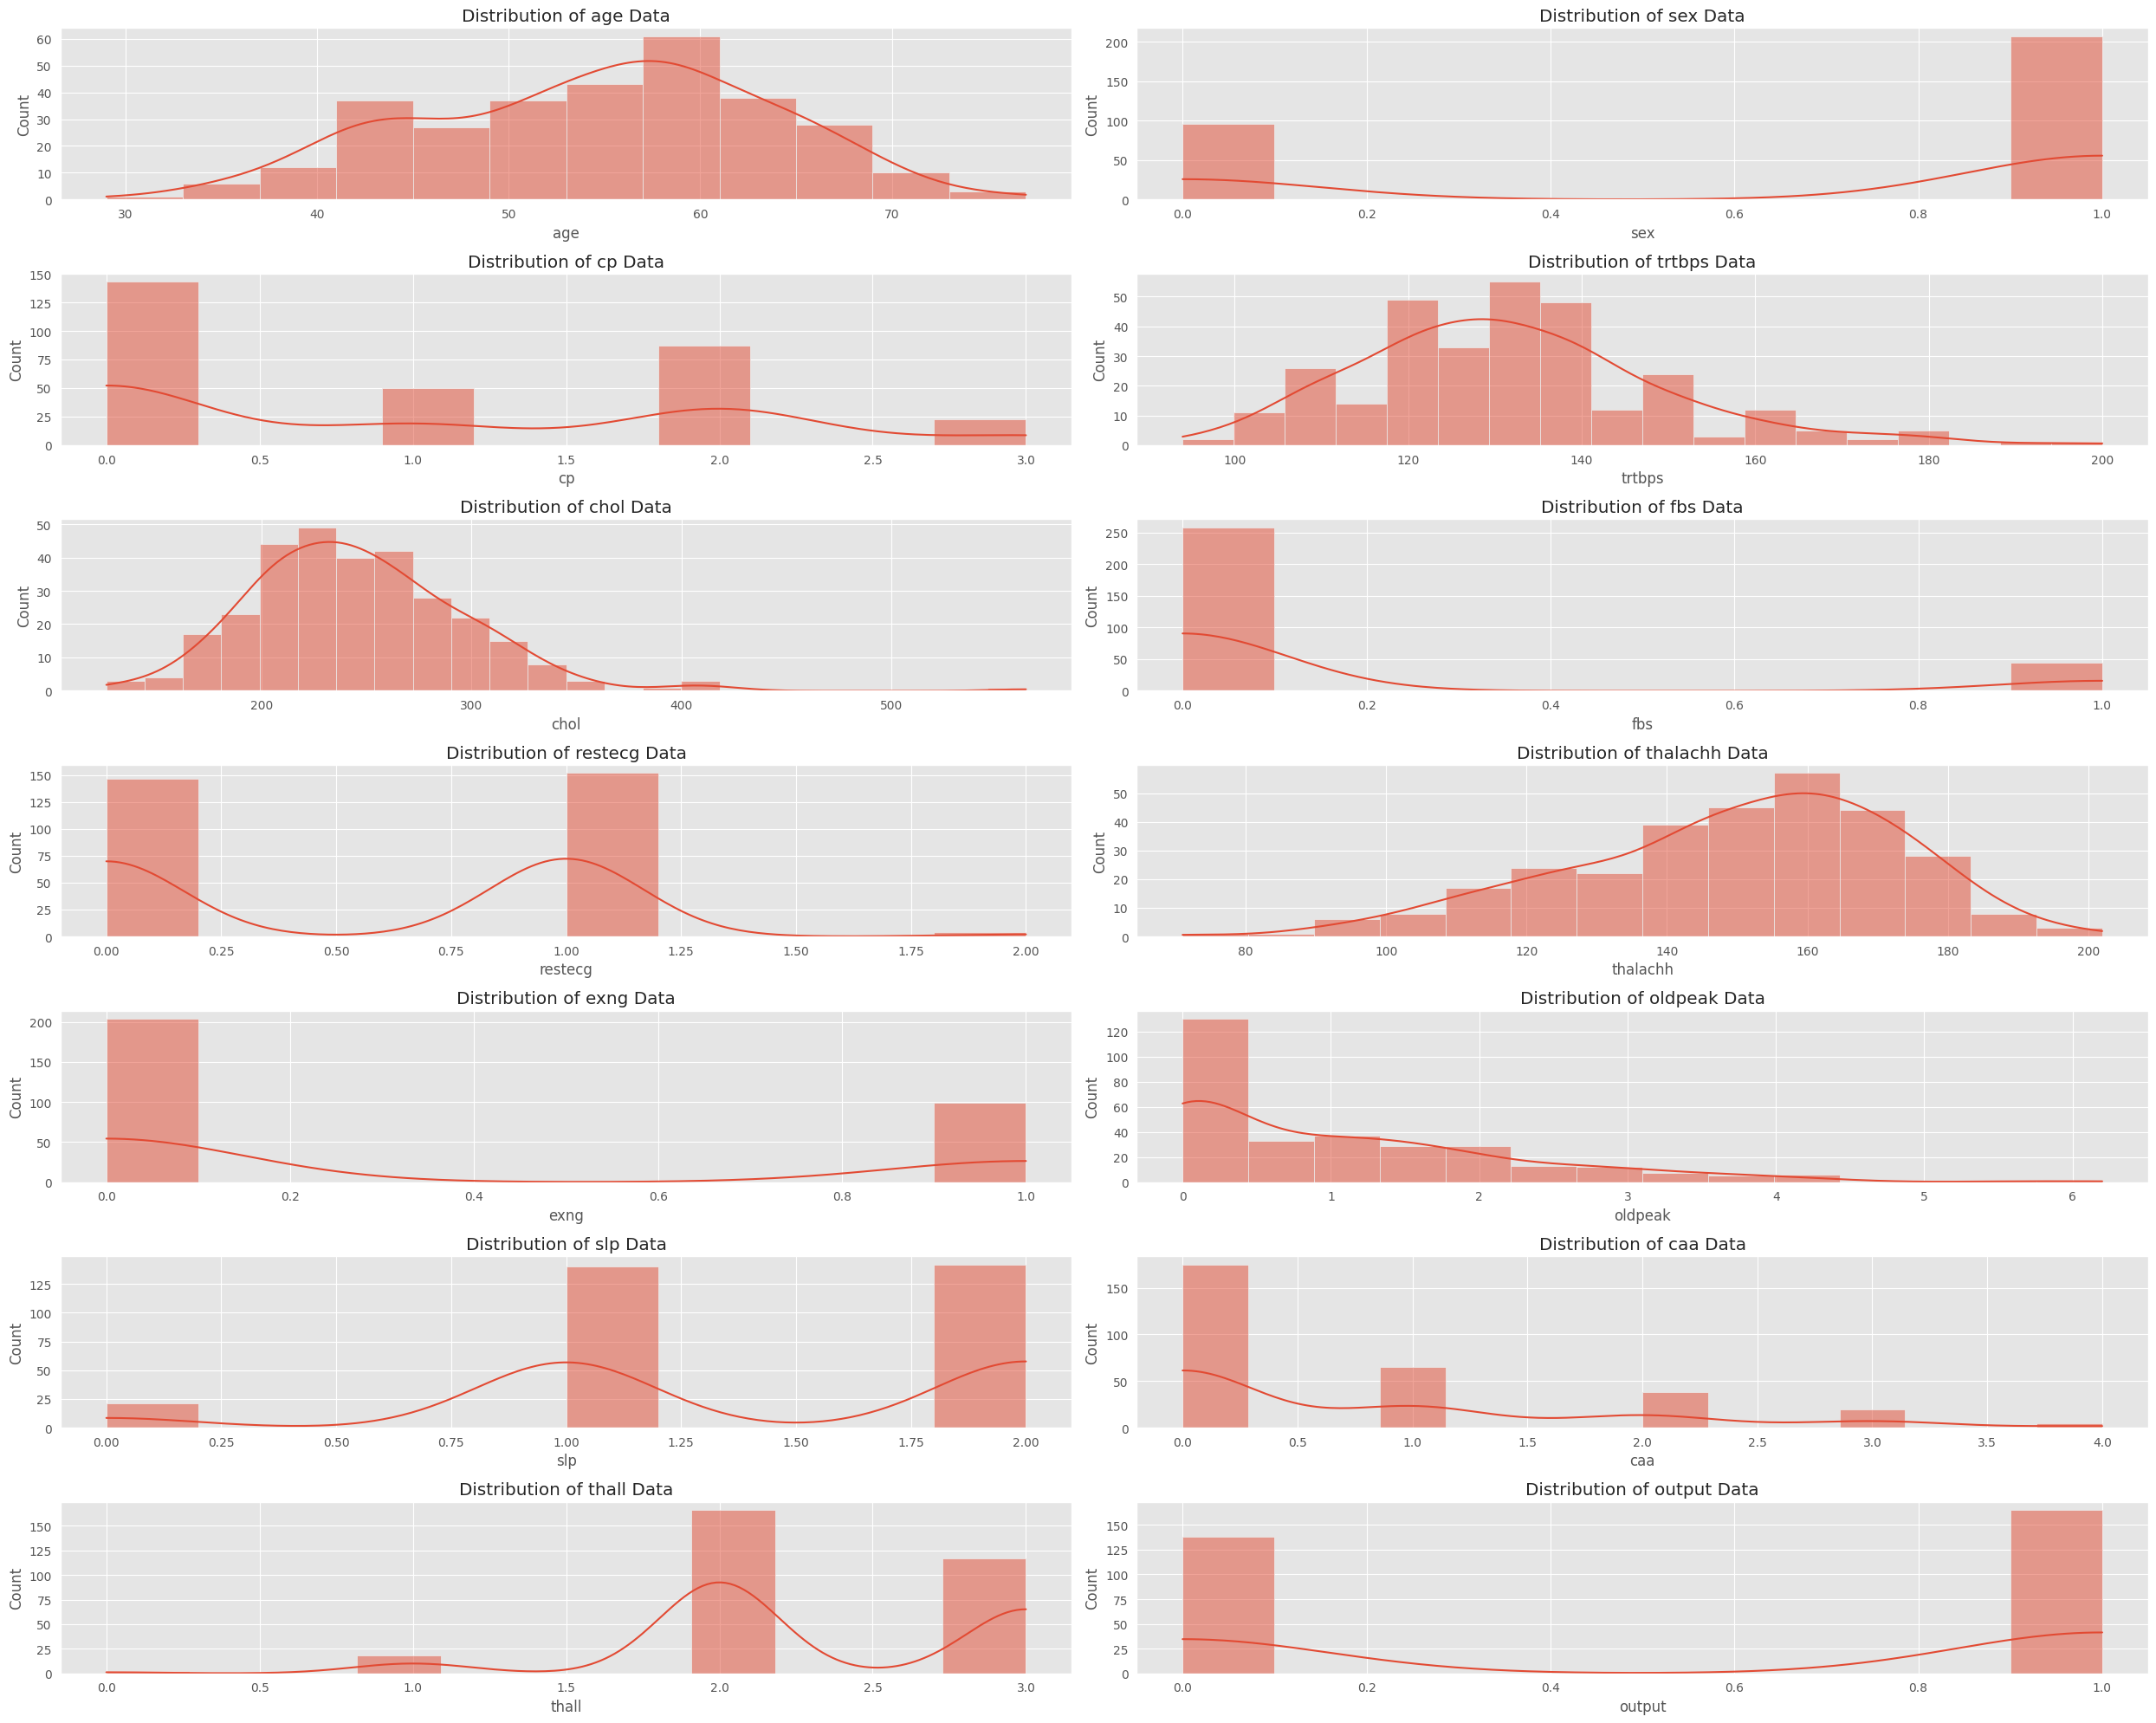

In [48]:
# Plot the distribution of features
plt.figure(figsize=(25,20))
for i,col in enumerate(heart_df.columns,1):
    plt.subplot(7,2,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(heart_df[col],kde=True)
    plt.tight_layout()
    plt.plot()

<Axes: xlabel='output', ylabel='slp'>

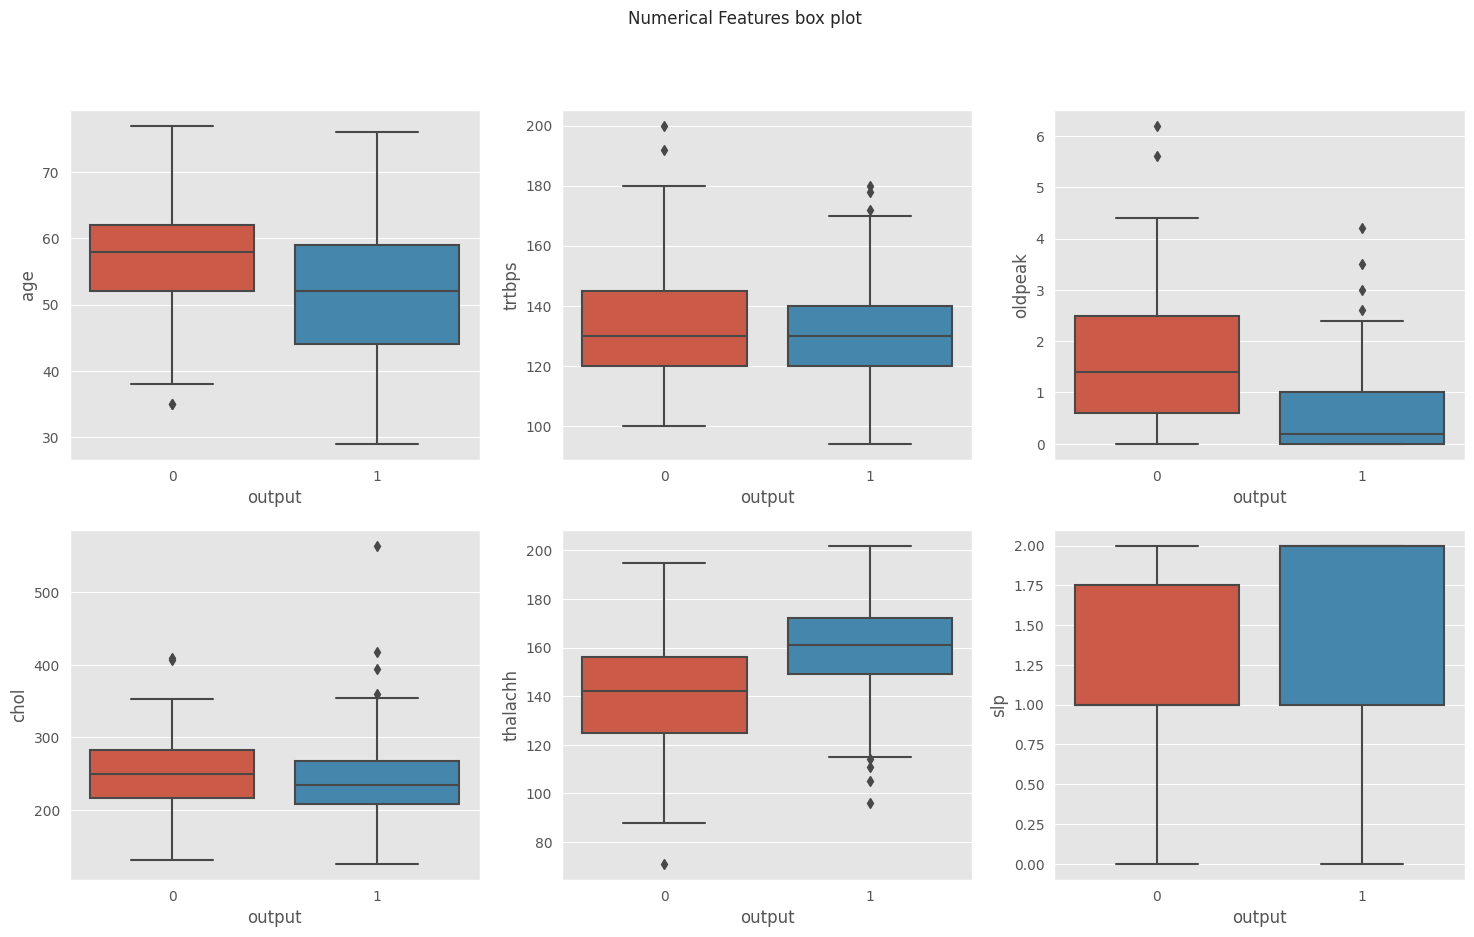

In [65]:
# Box plot the numerical features to check outliers
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Numerical Features box plot')

sns.boxplot(ax=axes[0, 0], data=heart_df, x='output', y='age')
sns.boxplot(ax=axes[0, 1], data=heart_df, x='output', y='trtbps')
sns.boxplot(ax=axes[0, 2], data=heart_df, x='output', y='oldpeak')
sns.boxplot(ax=axes[1, 0], data=heart_df, x='output', y='chol')
sns.boxplot(ax=axes[1, 1], data=heart_df, x='output', y='thalachh')
sns.boxplot(ax=axes[1, 2], data=heart_df, x='output', y='slp')

**There are not many outliers to throw off our model's training.**

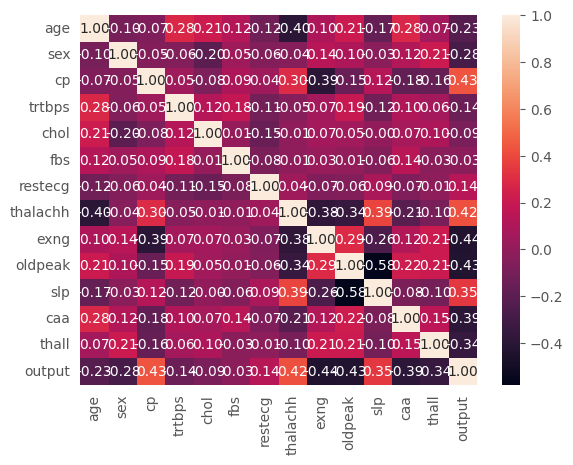

In [50]:
# Plot correlation matrix
corr_matrix = heart_df.corr(numeric_only = True)
ax = sns.heatmap(
    data = corr_matrix,
    annot = True,
    fmt = '.2f'
)

**There is a high correlation between some features, for example, age and halacha (maximum heart rate achieved), that is expected; however, considering the primary modeling technique used for this project(deep learning) and a low number of features, we can afford to use all the features we have. **

## 1. Preprocess the data

In [51]:
# Split the data to features and target
numeric_df = heart_df.astype(dtype="float")
X = numeric_df.copy()
X.drop(columns=["output"], inplace=True)
y = numeric_df["output"]

In [52]:
# Split the features and target to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.1)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [53]:
# Check random guess
heart_df["output"].value_counts()
low_risk_count = heart_df.loc[heart_df["output"]==0, ["output"]].count()
high_risk_count = heart_df.loc[heart_df["output"]==1, ["output"]].count()
random_guess = low_risk_count / (low_risk_count + high_risk_count)
print(f"Random Guess: {random_guess}")

Random Guess: output    0.455446
dtype: float64


## 2. Modeling
### 2.1 Neural Network Model

In [54]:
# Define the model

model = tf.keras.models.Sequential()

# First hidden layer
model.add(tf.keras.layers.Dense(units=32, input_dim=13 ,activation="relu"))

for i in range(5):
  # hidden layer
  model.add(tf.keras.layers.Dense(units=32, activation="relu"))

# Output layer
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 1)                 3

In [55]:
from keras.src.engine.training import optimizer
# Compile the model
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-2), metrics=["accuracy"])

In [56]:
# Train the model
heckpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/heart_attack_model_checkpoint.h5',  # Specify the file to save the model
    save_best_only=False,            # Save only the best model
    monitor='val_loss',              # Monitor the validation loss
    mode='min',                      # Mode can be 'min' or 'max' depending on the monitored metric
    save_weights_only=False,         # Save the entire model, not just weights
    save_freq=5                      # Save every 5 epochs
)
history = model.fit(X_train_scaled, y_train, epochs=55, batch_size=32, callbacks=heckpoint_callback, validation_data=(X_test_scaled, y_test))

Epoch 1/55
1/9 [==>...........................] - ETA: 16s - loss: 0.6869 - accuracy: 0.5625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 3s 100ms/step - loss: 0.6926 - accuracy: 0.5368 - val_loss: 0.6773 - val_accuracy: 0.6774
Epoch 2/55
9/9 [==============================] - 0s 15ms/step - loss: 0.6890 - accuracy: 0.5809 - val_loss: 0.6733 - val_accuracy: 0.6774
Epoch 3/55
9/9 [==============================] - 0s 23ms/step - loss: 0.6858 - accuracy: 0.5882 - val_loss: 0.6691 - val_accuracy: 0.7742
Epoch 4/55
9/9 [==============================] - 0s 25ms/step - loss: 0.6826 - accuracy: 0.6176 - val_loss: 0.6652 - val_accuracy: 0.7742
Epoch 5/55
9/9 [==============================] - 0s 25ms/step - loss: 0.6793 - accuracy: 0.6324 - val_loss: 0.6611 - val_accuracy: 0.8387
Epoch 6/55
9/9 [==============================] - 0s 15ms/step - loss: 0.6761 - accuracy: 0.6471 - val_loss: 0.6566 - val_accuracy: 0.8387
Epoch 7/55
9/9 [==============================] - 0s 16ms/step - loss: 0.6727 - accuracy: 0.6581 - val_loss: 0.6518 - val_accuracy: 0.8387
Epoch 8/55
9/9 [=====================

1/1 - 0s - loss: 0.3771 - accuracy: 0.8710 - 25ms/epoch - 25ms/step
Loss: 0.37714049220085144, Accuracy: 0.8709677457809448


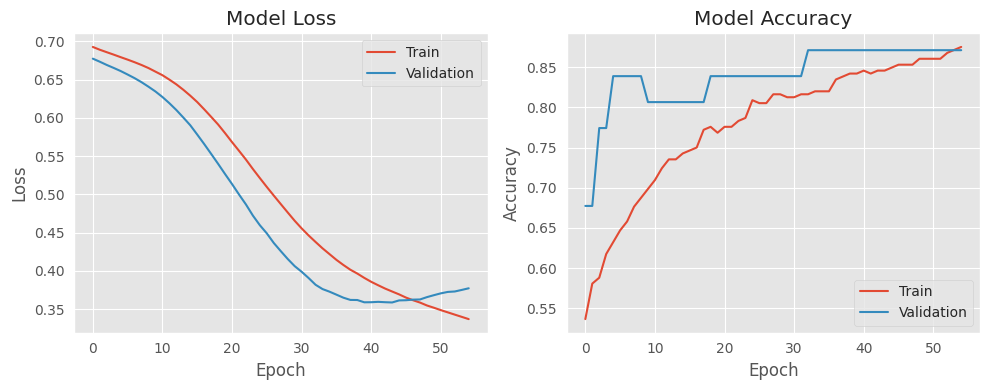

In [57]:
# Evaluate the model using the test data
model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# Plot training history (loss and accuracy)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Plot training & validation loss values
plt.subplot(121)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [59]:
model.export("/content/drive/MyDrive/ML /Real_heart_attack_prediction/nn_heat_attack.hdf5")

Saved artifact at '/content/drive/MyDrive/ML /Real_heart_attack_prediction/nn_heat_attack.hdf5'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, 13)
  Returns:
    float32 Tensor, shape=(None, 1)


### 2.2 Random Forest Model

In [58]:
# Make and fit the rf model
rf = RandomForestClassifier(n_estimators= 100)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [60]:
# Predict
y_pred = rf.predict(X_test_scaled)

In [61]:
# Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8709677419354839
Precision: 0.7894736842105263
Recall: 1.0


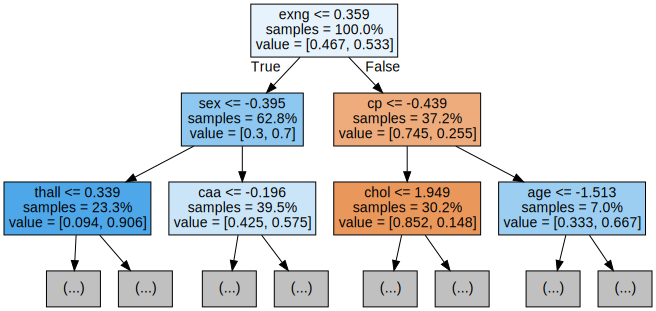

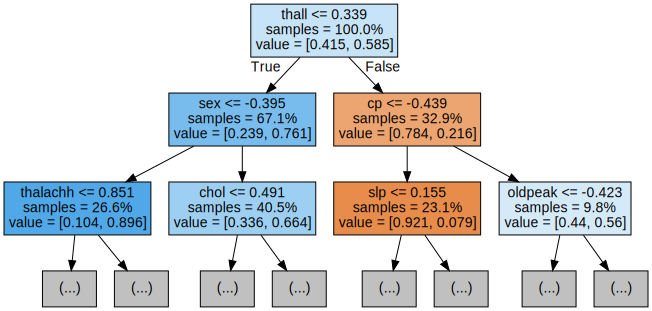

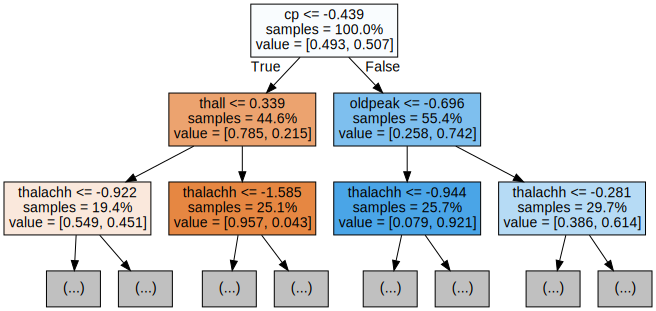

In [62]:
# Visualizing the Results
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

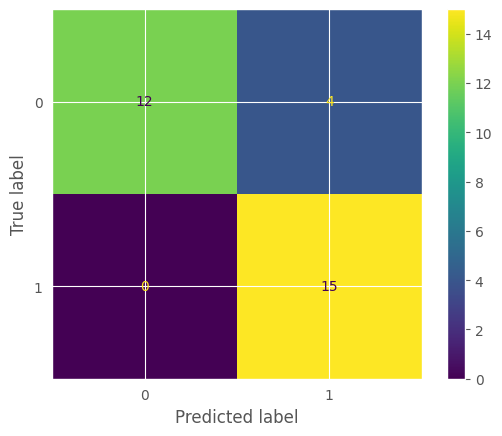

In [63]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

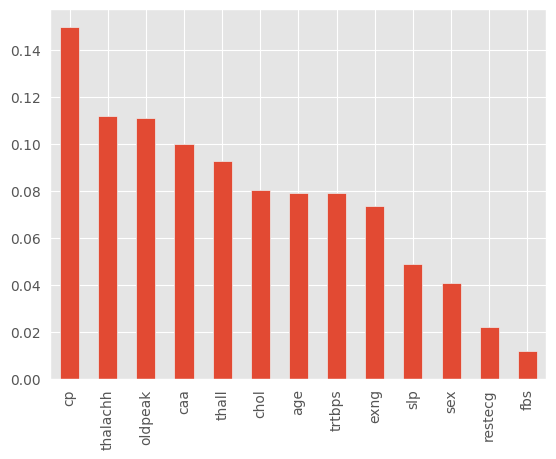

In [64]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();